In [1]:
import torch

In [2]:
if torch.cuda.is_available():
    print(f"GPU Device: {torch.cuda.get_device_name(0)}")
    print(f"Memory Allocated: {torch.cuda.memory_allocated(0)} bytes")
    print(f"Memory Cached: {torch.cuda.memory_reserved(0)} bytes")

GPU Device: Tesla V100-SXM2-16GB
Memory Allocated: 0 bytes
Memory Cached: 0 bytes


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import numpy as np
import pickle
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torch.optim as optim
from torchsummary import summary
from tqdm import tqdm
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import random
from torch.nn.utils import clip_grad_norm_
import torch.optim as optim
from torch.amp import GradScaler, autocast
from torch_optimizer import Lookahead 

### Model Definition

The model used for CIFAR-10 classification is a custom ResNet architecture, modified to include additional regularization and stochastic depth. Below are the key components of the model:

#### Residual Block
A key building block of the ResNet architecture is the **Residual Block**, which helps mitigate the vanishing gradient problem. Each block consists of two convolutional layers with batch normalization and ReLU activations. It also supports **dropout** and a **shortcut connection** that either performs identity mapping or a convolutional transformation if the input and output dimensions differ.

#### ResNet Architecture
The overall model is based on a modified version of ResNet, which includes multiple residual blocks with varying numbers of layers, along with enhanced regularization via dropout. Additionally, the stem of the network has been modified with a sequence of 3x3 convolutions. The model architecture is as follows:

1. **Stem Layer**: Initial convolutional layers followed by batch normalization and ReLU activation.
2. **Residual Layers**: Each of the layers (layer1, layer2, layer3, and layer4) contains multiple residual blocks, with the number of channels doubling after each layer.
3. **Final Layers**: An adaptive average pooling layer followed by a fully connected layer and dropout for classification.


In [14]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride, drop_rate):
        super().__init__()
        self.dropout = nn.Dropout2d(p=drop_rate) if drop_rate > 0 else None
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.AvgPool2d(2, stride=2) if stride == 2 else nn.Identity(),
                nn.Conv2d(in_channels, out_channels, 1, 1, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        if self.dropout:
            out = self.dropout(out)
        out += self.shortcut(x)
        return F.relu(out)


class ResNet(nn.Module):
    def __init__(self, drop_rate=0.2):
        super().__init__()
        self.in_channels = 32
        
        # Enhanced stem with multiple 3x3 convs (ResNet-D inspired)
        self.stem = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
        )
        
        # Modified layer configuration with stochastic depth
        self.layer1 = self._make_layer(32, 8, stride=1, drop_rate=drop_rate)
        self.layer2 = self._make_layer(64, 6, stride=2, drop_rate=drop_rate)
        self.layer3 = self._make_layer(128, 4, stride=2, drop_rate=drop_rate)
        self.layer4 = self._make_layer(256, 3, stride=2, drop_rate=drop_rate)
        
        # Final layers with enhanced regularization
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Dropout(drop_rate),
            nn.Linear(256, 10)
        )

    def _make_layer(self, channels, num_blocks, stride, drop_rate):
        layers = []
        layers.append(ResidualBlock(self.in_channels, channels, stride, 
                                          drop_rate))
        self.in_channels = channels
        for _ in range(1, num_blocks):
            layers.append(ResidualBlock(channels, channels, 1,
                                              drop_rate))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.stem(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        logits = self.fc(x)
        probabilities = F.softmax(logits, dim=1)
        return probabilities



model = ResNet()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

summary(model, input_size=(3, 32, 32), device=str(device))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 32, 32, 32]           9,216
       BatchNorm2d-5           [-1, 32, 32, 32]              64
              ReLU-6           [-1, 32, 32, 32]               0
            Conv2d-7           [-1, 32, 32, 32]           9,216
       BatchNorm2d-8           [-1, 32, 32, 32]              64
              ReLU-9           [-1, 32, 32, 32]               0
           Conv2d-10           [-1, 32, 32, 32]           9,216
      BatchNorm2d-11           [-1, 32, 32, 32]              64
           Conv2d-12           [-1, 32, 32, 32]           9,216
      BatchNorm2d-13           [-1, 32, 32, 32]              64
        Dropout2d-14           [-1, 32,

### Data Loading and Augmentation

In this study, we use the CIFAR-10 dataset for image classification, which consists of 60,000 32x32 color images in 10 classes. The dataset is loaded and augmented using a series of transformations to increase its variability and robustness.

#### Data Loading
The CIFAR-10 dataset is loaded using custom functions that handle the binary data batches stored in the dataset files. The function `load_cifar_batch` reads each batch, and `load_cifar10` loads the full training and test sets. The images are reshaped from a flat array into 3x32x32 format (RGB), and the labels are extracted for both training and test sets.

#### Data Augmentation
To improve the model's generalization, several data augmentations are applied to the training images. The augmentations include:

- **Random Horizontal Flip**: Randomly flips the image horizontally with a probability of 1.
- **Gaussian Blur**: Applies a Gaussian blur to simulate different levels of blurring in real-world images.
- **FiveCrop**: Crops the image into four corners and the center, then resizes them to the original size.
- **Grayscale Conversion**: Converts the image to grayscale and back to RGB.
- **Color Jitter**: Randomly adjusts the contrast and brightness of the image to simulate lighting variations.

These augmentations are applied to each image during training, significantly increasing the effective size of the dataset.

#### Dataset Class
The `CIFAR10Dataset` class is implemented to manage both the original and augmented images. The images are loaded and transformed using the defined transformations, and both the original and transformed images are stored for use during training. The data is loaded into batches using PyTorch’s `DataLoader`, enabling efficient training.

By incorporating these transformations, the dataset is expanded to help improve model robustness and reduce overfitting during training.


In [5]:

def load_cifar_batch(filename):
    with open(filename, 'rb') as f:
        batch = pickle.load(f, encoding='bytes')
    return batch

def load_cifar10(cifar10_dir):
    train_images = []
    train_labels = []

    for batch_id in range(1, 6):
        batch_dict = load_cifar_batch(os.path.join(cifar10_dir, f'data_batch_{batch_id}'))
        train_images.append(batch_dict[b'data'])
        train_labels.append(batch_dict[b'labels'])

    train_images = np.concatenate(train_images)
    train_labels = np.concatenate(train_labels)

    test_dict = load_cifar_batch(os.path.join(cifar10_dir, 'test_batch'))
    test_images = test_dict[b'data']
    test_labels = test_dict[b'labels']

    meta_data_dict = load_cifar_batch(os.path.join(cifar10_dir, 'batches.meta'))
    label_names = meta_data_dict[b'label_names']

    train_images = train_images.reshape((50000, 3, 32, 32)) 
    test_images = test_images.reshape((10000, 3, 32, 32))    

    train_images = np.transpose(train_images, (0, 2, 3, 1))
    test_images = np.transpose(test_images, (0, 2, 3, 1))
    
    return (train_images, train_labels), (test_images, test_labels), label_names

cifar10_dir = ''
(train_images, train_labels), (test_images, test_labels), label_names = load_cifar10(cifar10_dir)

transformations = [
    transforms.RandomHorizontalFlip(p=1),
    transforms.GaussianBlur(kernel_size=3),
    transforms.FiveCrop(20),
    transforms.Compose([
        transforms.Grayscale(num_output_channels=1),  
        transforms.Lambda(lambda x: x.convert('RGB'))
    ]),
    transforms.ColorJitter(contrast=0.5),
    transforms.ColorJitter(brightness=0.5)
]

def apply_transformations(image, transformations):
    transformed_images = []

    if not transformations:
        return transformed_images

    num_transformations = min(len(transformations), 10)
    selected_transforms = random.sample(transformations, num_transformations)

    for transform in selected_transforms:
        try:
            if isinstance(transform, transforms.FiveCrop):
                cropped_images = transform(image)
                for cropped_image in cropped_images:
                    resize_transform = transforms.Resize(32)
                    transformed_image = resize_transform(cropped_image)
                    transformed_images.append(transformed_image)
            else:
                transformed_image = transform(image)
                transformed_images.append(transformed_image)

        except Exception as e:
            print(f"Transformation failed: {e}")
            print(transform)
            continue
    
    return transformed_images

class CIFAR10Dataset(Dataset):
    def __init__(self, images, labels, transform=None, transformations=None):
        self.images = images
        self.labels = labels
        self.transform = transform
        self.transformations = transformations

        self.all_images = []
        self.all_labels = []
        for i in tqdm(range(len(images)), desc="Loading CIFAR-10 images and applying transformations", unit="image"):
            image = images[i]
            label = labels[i]
            if self.transform:
                image = self.transform(image)

            image_pil = transforms.ToPILImage()(image)
            
                
            self.all_images.append(image_pil)
            self.all_labels.append(label)
            
            transformed_images = apply_transformations(image_pil, transformations)
            self.all_images.extend(transformed_images)
            self.all_labels.extend([label] * len(transformed_images))

    def __len__(self):
        return len(self.all_images)

    def __getitem__(self, idx):
        image = self.all_images[idx]
        label = self.all_labels[idx]
        image = transforms.ToTensor()(image)
        return image, label



base_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
])

train_dataset = CIFAR10Dataset(train_images, train_labels, transform=base_transform, transformations=transformations)
test_dataset = CIFAR10Dataset(test_images, test_labels, transform=base_transform, transformations=transformations)

train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False, num_workers=4, pin_memory=True)

print(f"Original dataset size: {len(train_images)}")
print(f"After transformations, dataset size: {len(train_dataset)}")  # Now includes original + transformed images


Loading CIFAR-10 images and applying transformations: 100%|██████████| 50000/50000 [01:36<00:00, 518.09image/s]
Loading CIFAR-10 images and applying transformations: 100%|██████████| 10000/10000 [00:19<00:00, 520.83image/s]

Original dataset size: 50000
After transformations, dataset size: 550000


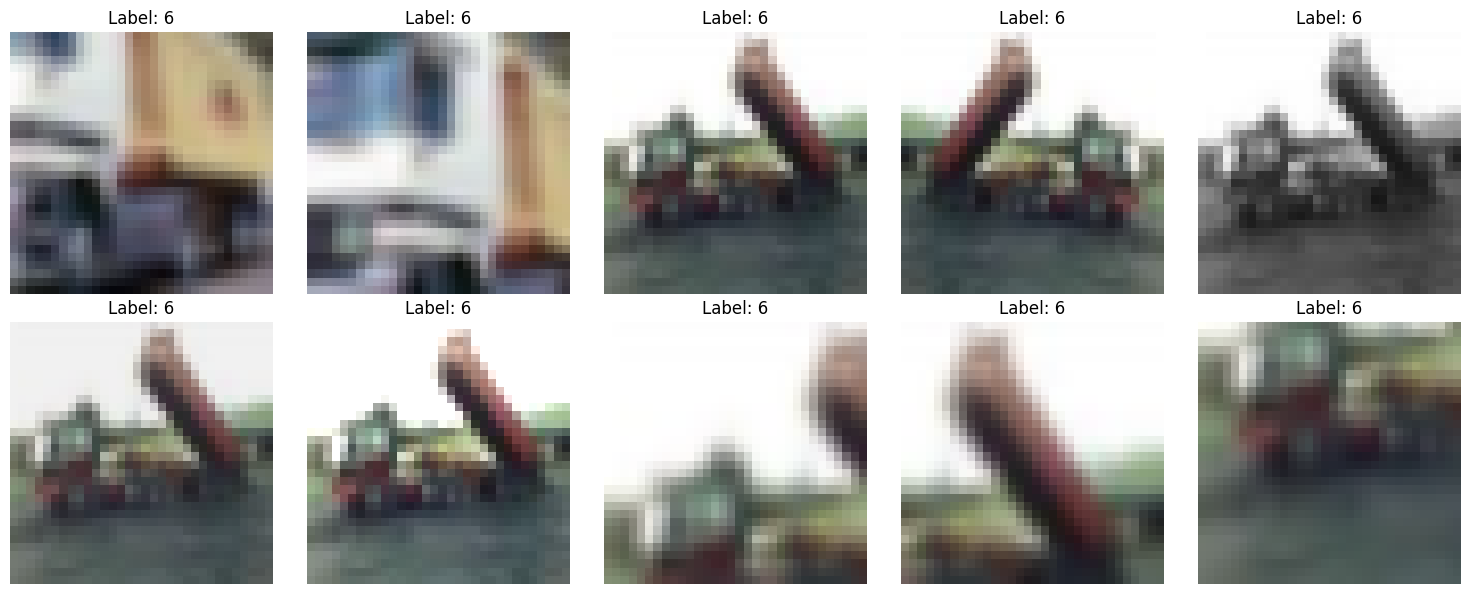

In [6]:
top_10_images = [train_dataset[i+20][0] for i in range(10)]
top_10_labels = [train_dataset[i][1] for i in range(10)]

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(top_10_images[i].permute(1, 2, 0))
    ax.set_title(f"Label: {top_10_labels[i]}")
    ax.axis('off')

plt.tight_layout()
plt.show()

In [7]:
# Load Submission Test Data
class CIFAR10DatasetTest(Dataset):
    def __init__(self, images, ids, transform=None):
        self.images = images
        self.ids = ids
        self.transform = transform

        self.all_images = []
        self.all_ids = []
        for i in tqdm(range(len(images)), desc="Loading Final Submission CIFAR-10 images", unit="image"):
            image = images[i]
            _id = ids[i]
            if self.transform:
                image = self.transform(image)
            self.all_images.append(image)
            self.all_ids.append(_id)

    def __len__(self):
        return len(self.all_images)

    def __getitem__(self, idx):
        image = self.all_images[idx]
        _id = self.all_ids[idx]
        return image, _id

cifar10_batch = load_cifar_batch('cifar_test_nolabel.pkl')

submission_images = cifar10_batch[b'data']
submission_ids = cifar10_batch[b'ids']


submission_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),    
])

submission_dataset = CIFAR10DatasetTest(submission_images, submission_ids, transform = submission_transform)
submission_loader = DataLoader(submission_dataset, batch_size=256, shuffle=False, num_workers=4, pin_memory=False)


Loading Final Submission CIFAR-10 images: 100%|██████████| 10000/10000 [00:01<00:00, 7488.73image/s]


### Model Loading and GPU Setup

The model is configured to run on multiple GPUs if available. This is done by checking the number of available GPUs using `torch.cuda.device_count()`. 

- **Multi-GPU Setup**: If more than one GPU is available, the model is wrapped with `nn.DataParallel` to enable parallel processing across the GPUs. The model is then moved to the appropriate device (GPU or CPU).
- **Single-GPU or CPU Setup**: If only one GPU or no GPU is available, the model is directly moved to the available device (CPU or GPU).

Additionally, a checkpoint for the model weights can be loaded using `model.load_state_dict(torch.load('MWT_best.pth'))` (currently commented out), which allows the model to resume from the best previously saved state.

This approach optimizes the model's training and inference by utilizing multiple GPUs when available, making the process faster and more efficient.


In [15]:
# Uncomment model.load_state_dict to load a best saved checkpoint if available
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs!")
    model = nn.DataParallel(model)
    model = model.to(device)
    # model.load_state_dict(torch.load('MWT_best.pth'))
else:
    model = model.to(device)
    # model.load_state_dict(torch.load('MWT_best.pth'))

Using 2 GPUs!


### Model Training

The model is trained for a total of 50 epochs with the following setup:

- **Optimizer**: The training process uses the **SGD** optimizer with a learning rate of 0.1, momentum of 0.95, and Nesterov acceleration. Weight decay is set to 4e-5 to prevent overfitting. Additionally, the **Lookahead** mechanism is applied to the optimizer, with `k=5` and `alpha=0.8`, which helps improve generalization by maintaining a slower-moving "slow" model in the training process.
  
- **Learning Rate Scheduler**: A **OneCycleLR** scheduler is employed, with a maximum learning rate of 0.1. The scheduler gradually increases the learning rate over the first 25% of training epochs and then decreases it, following a cosine annealing schedule.

- **Loss Function**: The loss function used is **Smooth Cross-Entropy** with label smoothing. The smoothing factor is set to 0.1, which helps to prevent overfitting by making the model less confident in its predictions.

- **Mixed Precision Training**: The **GradScaler** from PyTorch’s mixed-precision module is used to scale gradients during the backward pass to speed up training while preserving numerical stability.

The model training loop consists of:
1. **Training Loop**: For each epoch, the model is trained using batches from the `train_loader`. The loss and accuracy are calculated and printed for each epoch.
2. **Gradient Clipping**: Gradient clipping is applied to avoid exploding gradients by limiting the norm of the gradients.
3. **Early Stopping**: The training loop includes early stopping criteria, halting training if the test accuracy does not improve by more than 0.1% for 8 consecutive epochs.
4. **Model Checkpointing**: The best model (in terms of test accuracy) is saved periodically using `torch.save(model.state_dict(), 'MWT_best.pth')`.

The model is tested on the test set using the `test` function after every epoch, and the test loss and accuracy are reported. At the end of the training process, the final model is saved to 'MWT.pth'.


In [16]:
n_epochs = 50

base_optimizer = optim.SGD(model.parameters(), lr=0.1,
                          momentum=0.95, nesterov=True,
                          weight_decay=4e-5)
optimizer = Lookahead(base_optimizer, k=5, alpha=0.8)

scheduler = optim.lr_scheduler.OneCycleLR(optimizer, 
                                        max_lr=0.1,
                                        total_steps=n_epochs *len(train_loader),
                                        pct_start=0.25,
                                        anneal_strategy='cos')

scaler = GradScaler('cuda')

train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

class SmoothCrossEntropy(nn.Module):
    def __init__(self, smoothing=0.1):
        super().__init__()
        self.smoothing = smoothing
        self.confidence = 1.0 - smoothing
    
    def forward(self, outputs, targets):
        num_classes = outputs.size(-1)
        log_preds = F.log_softmax(outputs, dim=-1)
        true_dist = torch.zeros_like(log_preds)
        true_dist.fill_(self.smoothing / (num_classes - 1))
        true_dist.scatter_(1, targets.data.unsqueeze(1), self.confidence)
        return torch.mean(-torch.sum(true_dist * log_preds, dim=-1))

criterion = SmoothCrossEntropy(smoothing=0.1)

def test(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Testing"):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = running_loss / len(test_loader)
    accuracy = 100 * correct / total
    print(f"Test Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")
    
    return avg_loss, accuracy

def train(model, train_loader, optimizer, criterion, scheduler, scaler, epoch, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, targets in tqdm(train_loader, desc=f"Epoch {epoch} - Training"):
        inputs, targets = inputs.to('cuda'), targets.to('cuda')
        
        with autocast('cuda'):
            outputs = model(inputs)
            loss = criterion(outputs, targets)
        
        optimizer.zero_grad(set_to_none=True)
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        clip_grad_norm_(model.parameters(), 0.1)
        
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    
    avg_loss = running_loss / len(train_loader)
    accuracy = 100 * correct / total
    print(f"Train Epoch: {epoch}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")
    
    return avg_loss, accuracy
    
prev_acc = 0.0
_, best_acc = test(model, test_loader, criterion, device)
count = 0
for epoch in range(n_epochs):
    train_loss, train_accuracy = train(model, train_loader, optimizer, criterion, scheduler, scaler, epoch+1, device)
    test_loss, test_accuracy = test(model, test_loader, criterion, device)
    
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    
    if(test_accuracy - prev_acc < 0.1):
        count+=1
        if(count>8):
            break
    else:
        count = 0

    if best_acc <= test_accuracy:
        best_acc = test_accuracy
        torch.save(model.state_dict(), 'MWT_best.pth')
    prev_acc = test_accuracy


test_dataset_og = CIFAR10Dataset(test_images, test_labels, transform=base_transform, transformations=None)
test_loader_og = DataLoader(test_dataset_og, batch_size=256, shuffle=False, num_workers=4, pin_memory=True)

test(model, test_loader_og, criterion, device)

torch.save(model.state_dict(), 'MWT.pth')

Testing: 100%|██████████| 215/215 [00:10<00:00, 19.81it/s]


Test Loss: 2.3026, Accuracy: 10.00%


Epoch 1 - Training: 100%|██████████| 1075/1075 [02:01<00:00,  8.88it/s]


Train Epoch: 1, Loss: 2.2672, Accuracy: 16.90%


Testing: 100%|██████████| 215/215 [00:10<00:00, 20.77it/s]


Test Loss: 2.2672, Accuracy: 17.18%


Epoch 2 - Training: 100%|██████████| 1075/1075 [02:01<00:00,  8.86it/s]


Train Epoch: 2, Loss: 2.2103, Accuracy: 24.91%


Testing: 100%|██████████| 215/215 [00:09<00:00, 21.83it/s]


Test Loss: 2.2017, Accuracy: 25.53%


Epoch 3 - Training: 100%|██████████| 1075/1075 [02:00<00:00,  8.93it/s]


Train Epoch: 3, Loss: 2.1468, Accuracy: 33.00%


Testing: 100%|██████████| 215/215 [00:09<00:00, 21.92it/s]


Test Loss: 2.1225, Accuracy: 35.64%


Epoch 4 - Training: 100%|██████████| 1075/1075 [02:00<00:00,  8.94it/s]


Train Epoch: 4, Loss: 2.1057, Accuracy: 37.84%


Testing: 100%|██████████| 215/215 [00:09<00:00, 22.08it/s]


Test Loss: 2.0823, Accuracy: 40.56%


Epoch 5 - Training: 100%|██████████| 1075/1075 [02:00<00:00,  8.96it/s]


Train Epoch: 5, Loss: 2.0760, Accuracy: 41.28%


Testing: 100%|██████████| 215/215 [00:10<00:00, 21.13it/s]


Test Loss: 2.0683, Accuracy: 42.23%


Epoch 6 - Training: 100%|██████████| 1075/1075 [02:01<00:00,  8.87it/s]


Train Epoch: 6, Loss: 2.0461, Accuracy: 44.87%


Testing: 100%|██████████| 215/215 [00:09<00:00, 21.66it/s]


Test Loss: 2.0329, Accuracy: 46.21%


Epoch 7 - Training: 100%|██████████| 1075/1075 [02:01<00:00,  8.86it/s]


Train Epoch: 7, Loss: 2.0141, Accuracy: 48.58%


Testing: 100%|██████████| 215/215 [00:09<00:00, 21.56it/s]


Test Loss: 1.9933, Accuracy: 50.85%


Epoch 8 - Training: 100%|██████████| 1075/1075 [02:00<00:00,  8.89it/s]


Train Epoch: 8, Loss: 1.9853, Accuracy: 51.93%


Testing: 100%|██████████| 215/215 [00:09<00:00, 21.77it/s]


Test Loss: 1.9598, Accuracy: 54.76%


Epoch 9 - Training: 100%|██████████| 1075/1075 [02:02<00:00,  8.79it/s]


Train Epoch: 9, Loss: 1.9625, Accuracy: 54.55%


Testing: 100%|██████████| 215/215 [00:09<00:00, 21.67it/s]


Test Loss: 1.9452, Accuracy: 56.36%


Epoch 10 - Training: 100%|██████████| 1075/1075 [02:01<00:00,  8.87it/s]


Train Epoch: 10, Loss: 1.9427, Accuracy: 56.78%


Testing: 100%|██████████| 215/215 [00:09<00:00, 21.77it/s]


Test Loss: 1.9299, Accuracy: 58.12%


Epoch 11 - Training: 100%|██████████| 1075/1075 [02:01<00:00,  8.82it/s]


Train Epoch: 11, Loss: 1.9171, Accuracy: 59.87%


Testing: 100%|██████████| 215/215 [00:09<00:00, 21.74it/s]


Test Loss: 1.8927, Accuracy: 62.46%


Epoch 12 - Training: 100%|██████████| 1075/1075 [02:00<00:00,  8.95it/s]


Train Epoch: 12, Loss: 1.8931, Accuracy: 62.56%


Testing: 100%|██████████| 215/215 [00:10<00:00, 20.47it/s]


Test Loss: 1.8737, Accuracy: 64.62%


Epoch 13 - Training: 100%|██████████| 1075/1075 [01:59<00:00,  8.96it/s]


Train Epoch: 13, Loss: 1.8737, Accuracy: 64.78%


Testing: 100%|██████████| 215/215 [00:09<00:00, 22.02it/s]


Test Loss: 1.8591, Accuracy: 66.21%


Epoch 14 - Training: 100%|██████████| 1075/1075 [02:01<00:00,  8.85it/s]


Train Epoch: 14, Loss: 1.8566, Accuracy: 66.70%


Testing: 100%|██████████| 215/215 [00:09<00:00, 21.82it/s]


Test Loss: 1.8429, Accuracy: 68.05%


Epoch 15 - Training: 100%|██████████| 1075/1075 [02:00<00:00,  8.91it/s]


Train Epoch: 15, Loss: 1.8413, Accuracy: 68.45%


Testing: 100%|██████████| 215/215 [00:09<00:00, 21.63it/s]


Test Loss: 1.8274, Accuracy: 69.93%


Epoch 16 - Training: 100%|██████████| 1075/1075 [02:01<00:00,  8.84it/s]


Train Epoch: 16, Loss: 1.8282, Accuracy: 69.94%


Testing: 100%|██████████| 215/215 [00:10<00:00, 21.35it/s]


Test Loss: 1.8154, Accuracy: 71.25%


Epoch 17 - Training: 100%|██████████| 1075/1075 [01:59<00:00,  8.96it/s]


Train Epoch: 17, Loss: 1.8155, Accuracy: 71.42%


Testing: 100%|██████████| 215/215 [00:09<00:00, 21.96it/s]


Test Loss: 1.8200, Accuracy: 70.68%


Epoch 18 - Training: 100%|██████████| 1075/1075 [02:00<00:00,  8.96it/s]


Train Epoch: 18, Loss: 1.8045, Accuracy: 72.67%


Testing: 100%|██████████| 215/215 [00:09<00:00, 21.93it/s]


Test Loss: 1.8189, Accuracy: 70.84%


Epoch 19 - Training: 100%|██████████| 1075/1075 [02:00<00:00,  8.89it/s]


Train Epoch: 19, Loss: 1.7950, Accuracy: 73.77%


Testing: 100%|██████████| 215/215 [00:09<00:00, 22.12it/s]


Test Loss: 1.7865, Accuracy: 74.47%


Epoch 20 - Training: 100%|██████████| 1075/1075 [02:00<00:00,  8.92it/s]


Train Epoch: 20, Loss: 1.7857, Accuracy: 74.82%


Testing: 100%|██████████| 215/215 [00:09<00:00, 21.73it/s]


Test Loss: 1.7812, Accuracy: 75.16%


Epoch 21 - Training: 100%|██████████| 1075/1075 [02:00<00:00,  8.92it/s]


Train Epoch: 21, Loss: 1.7776, Accuracy: 75.76%


Testing: 100%|██████████| 215/215 [00:09<00:00, 21.89it/s]


Test Loss: 1.7815, Accuracy: 75.11%


Epoch 22 - Training: 100%|██████████| 1075/1075 [02:01<00:00,  8.86it/s]


Train Epoch: 22, Loss: 1.7702, Accuracy: 76.59%


Testing: 100%|██████████| 215/215 [00:09<00:00, 21.97it/s]


Test Loss: 1.7734, Accuracy: 75.94%


Epoch 23 - Training: 100%|██████████| 1075/1075 [02:01<00:00,  8.87it/s]


Train Epoch: 23, Loss: 1.7628, Accuracy: 77.45%


Testing: 100%|██████████| 215/215 [00:09<00:00, 21.93it/s]


Test Loss: 1.7664, Accuracy: 76.82%


Epoch 24 - Training: 100%|██████████| 1075/1075 [01:59<00:00,  8.98it/s]


Train Epoch: 24, Loss: 1.7563, Accuracy: 78.21%


Testing: 100%|██████████| 215/215 [00:10<00:00, 21.45it/s]


Test Loss: 1.7620, Accuracy: 77.26%


Epoch 25 - Training: 100%|██████████| 1075/1075 [01:59<00:00,  9.00it/s]


Train Epoch: 25, Loss: 1.7504, Accuracy: 78.86%


Testing: 100%|██████████| 215/215 [00:09<00:00, 21.77it/s]


Test Loss: 1.7569, Accuracy: 77.95%


Epoch 26 - Training: 100%|██████████| 1075/1075 [02:00<00:00,  8.92it/s]


Train Epoch: 26, Loss: 1.7444, Accuracy: 79.54%


Testing: 100%|██████████| 215/215 [00:09<00:00, 21.69it/s]


Test Loss: 1.7587, Accuracy: 77.68%


Epoch 27 - Training: 100%|██████████| 1075/1075 [02:01<00:00,  8.86it/s]


Train Epoch: 27, Loss: 1.7390, Accuracy: 80.15%


Testing: 100%|██████████| 215/215 [00:09<00:00, 21.58it/s]


Test Loss: 1.7515, Accuracy: 78.51%


Epoch 28 - Training: 100%|██████████| 1075/1075 [02:00<00:00,  8.94it/s]


Train Epoch: 28, Loss: 1.7331, Accuracy: 80.84%


Testing: 100%|██████████| 215/215 [00:09<00:00, 21.95it/s]


Test Loss: 1.7482, Accuracy: 78.92%


Epoch 29 - Training: 100%|██████████| 1075/1075 [02:02<00:00,  8.80it/s]


Train Epoch: 29, Loss: 1.7284, Accuracy: 81.38%


Testing: 100%|██████████| 215/215 [00:09<00:00, 21.55it/s]


Test Loss: 1.7454, Accuracy: 79.21%


Epoch 30 - Training: 100%|██████████| 1075/1075 [01:59<00:00,  9.00it/s]


Train Epoch: 30, Loss: 1.7233, Accuracy: 81.96%


Testing: 100%|██████████| 215/215 [00:09<00:00, 22.26it/s]


Test Loss: 1.7391, Accuracy: 79.95%


Epoch 31 - Training: 100%|██████████| 1075/1075 [01:59<00:00,  9.03it/s]


Train Epoch: 31, Loss: 1.7188, Accuracy: 82.49%


Testing: 100%|██████████| 215/215 [00:09<00:00, 22.01it/s]


Test Loss: 1.7347, Accuracy: 80.42%


Epoch 32 - Training: 100%|██████████| 1075/1075 [01:58<00:00,  9.04it/s]


Train Epoch: 32, Loss: 1.7140, Accuracy: 83.02%


Testing: 100%|██████████| 215/215 [00:09<00:00, 22.18it/s]


Test Loss: 1.7364, Accuracy: 80.20%


Epoch 33 - Training: 100%|██████████| 1075/1075 [02:00<00:00,  8.94it/s]


Train Epoch: 33, Loss: 1.7099, Accuracy: 83.51%


Testing: 100%|██████████| 215/215 [00:10<00:00, 20.88it/s]


Test Loss: 1.7305, Accuracy: 80.89%


Epoch 34 - Training: 100%|██████████| 1075/1075 [02:01<00:00,  8.85it/s]


Train Epoch: 34, Loss: 1.7059, Accuracy: 83.96%


Testing: 100%|██████████| 215/215 [00:10<00:00, 21.50it/s]


Test Loss: 1.7296, Accuracy: 80.98%


Epoch 35 - Training: 100%|██████████| 1075/1075 [01:59<00:00,  8.97it/s]


Train Epoch: 35, Loss: 1.7012, Accuracy: 84.51%


Testing: 100%|██████████| 215/215 [00:10<00:00, 20.52it/s]


Test Loss: 1.7271, Accuracy: 81.30%


Epoch 36 - Training: 100%|██████████| 1075/1075 [02:00<00:00,  8.95it/s]


Train Epoch: 36, Loss: 1.6977, Accuracy: 84.91%


Testing: 100%|██████████| 215/215 [00:09<00:00, 21.87it/s]


Test Loss: 1.7255, Accuracy: 81.50%


Epoch 37 - Training: 100%|██████████| 1075/1075 [02:00<00:00,  8.93it/s]


Train Epoch: 37, Loss: 1.6935, Accuracy: 85.37%


Testing: 100%|██████████| 215/215 [00:09<00:00, 22.04it/s]


Test Loss: 1.7213, Accuracy: 81.90%


Epoch 38 - Training: 100%|██████████| 1075/1075 [02:00<00:00,  8.95it/s]


Train Epoch: 38, Loss: 1.6897, Accuracy: 85.80%


Testing: 100%|██████████| 215/215 [00:10<00:00, 21.44it/s]


Test Loss: 1.7185, Accuracy: 82.25%


Epoch 39 - Training: 100%|██████████| 1075/1075 [02:00<00:00,  8.94it/s]


Train Epoch: 39, Loss: 1.6864, Accuracy: 86.21%


Testing: 100%|██████████| 215/215 [00:09<00:00, 21.71it/s]


Test Loss: 1.7152, Accuracy: 82.62%


Epoch 40 - Training: 100%|██████████| 1075/1075 [01:59<00:00,  9.03it/s]


Train Epoch: 40, Loss: 1.6826, Accuracy: 86.62%


Testing: 100%|██████████| 215/215 [00:09<00:00, 22.22it/s]


Test Loss: 1.7155, Accuracy: 82.59%


Epoch 41 - Training: 100%|██████████| 1075/1075 [01:59<00:00,  8.99it/s]


Train Epoch: 41, Loss: 1.6796, Accuracy: 86.97%


Testing: 100%|██████████| 215/215 [00:09<00:00, 22.09it/s]


Test Loss: 1.7142, Accuracy: 82.73%


Epoch 42 - Training: 100%|██████████| 1075/1075 [01:59<00:00,  9.01it/s]


Train Epoch: 42, Loss: 1.6762, Accuracy: 87.36%


Testing: 100%|██████████| 215/215 [00:09<00:00, 22.33it/s]


Test Loss: 1.7114, Accuracy: 83.09%


Epoch 43 - Training: 100%|██████████| 1075/1075 [01:59<00:00,  9.03it/s]


Train Epoch: 43, Loss: 1.6733, Accuracy: 87.67%


Testing: 100%|██████████| 215/215 [00:09<00:00, 22.05it/s]


Test Loss: 1.7123, Accuracy: 82.97%


Epoch 44 - Training: 100%|██████████| 1075/1075 [01:59<00:00,  8.99it/s]


Train Epoch: 44, Loss: 1.6706, Accuracy: 88.01%


Testing: 100%|██████████| 215/215 [00:09<00:00, 22.11it/s]


Test Loss: 1.7087, Accuracy: 83.39%


Epoch 45 - Training: 100%|██████████| 1075/1075 [01:58<00:00,  9.04it/s]


Train Epoch: 45, Loss: 1.6687, Accuracy: 88.19%


Testing: 100%|██████████| 215/215 [00:09<00:00, 21.98it/s]


Test Loss: 1.7085, Accuracy: 83.38%


Epoch 46 - Training: 100%|██████████| 1075/1075 [01:58<00:00,  9.05it/s]


Train Epoch: 46, Loss: 1.6665, Accuracy: 88.43%


Testing: 100%|██████████| 215/215 [00:10<00:00, 20.80it/s]


Test Loss: 1.7078, Accuracy: 83.48%


Epoch 47 - Training: 100%|██████████| 1075/1075 [01:58<00:00,  9.06it/s]


Train Epoch: 47, Loss: 1.6649, Accuracy: 88.64%


Testing: 100%|██████████| 215/215 [00:09<00:00, 22.19it/s]


Test Loss: 1.7071, Accuracy: 83.54%


Epoch 48 - Training: 100%|██████████| 1075/1075 [01:59<00:00,  9.01it/s]


Train Epoch: 48, Loss: 1.6635, Accuracy: 88.81%


Testing: 100%|██████████| 215/215 [00:09<00:00, 22.24it/s]


Test Loss: 1.7064, Accuracy: 83.62%


Epoch 49 - Training: 100%|██████████| 1075/1075 [01:58<00:00,  9.05it/s]


Train Epoch: 49, Loss: 1.6629, Accuracy: 88.86%


Testing: 100%|██████████| 215/215 [00:09<00:00, 22.08it/s]


Test Loss: 1.7060, Accuracy: 83.71%


Epoch 50 - Training: 100%|██████████| 1075/1075 [01:58<00:00,  9.06it/s]


Train Epoch: 50, Loss: 1.6628, Accuracy: 88.89%


Testing: 100%|██████████| 215/215 [00:09<00:00, 22.25it/s]


Test Loss: 1.7062, Accuracy: 83.68%


Loading CIFAR-10 images and applying transformations: 100%|██████████| 10000/10000 [00:02<00:00, 4102.01image/s]
Testing: 100%|██████████| 40/40 [00:02<00:00, 19.39it/s]


Test Loss: 1.6509, Accuracy: 90.05%


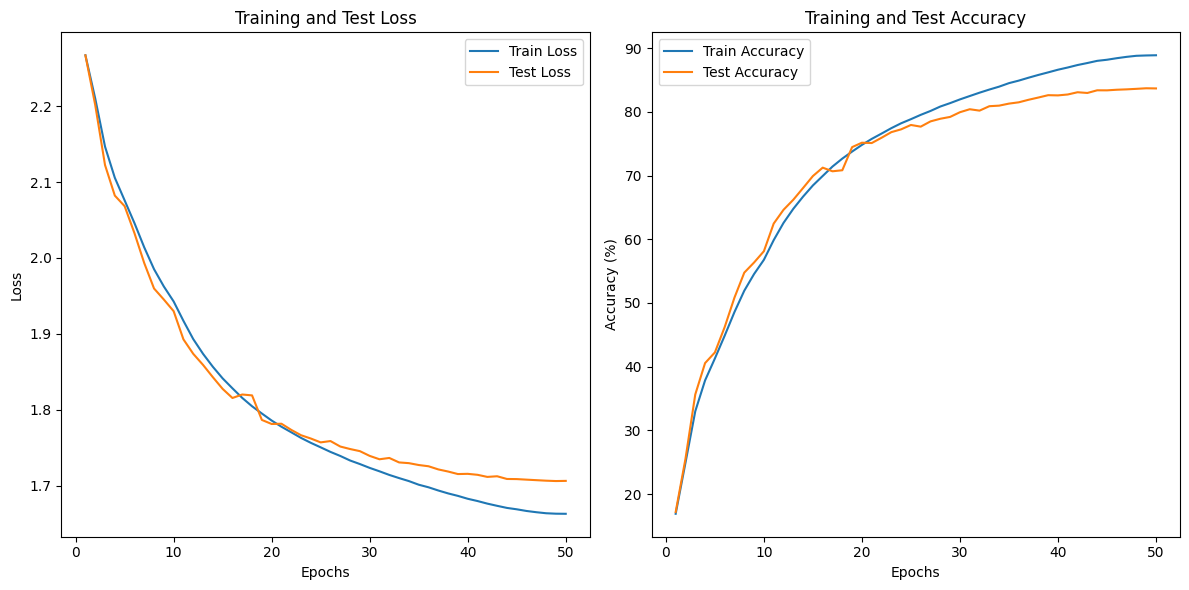

In [17]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, n_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, n_epochs + 1), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Test Loss')

# Plot training and test accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, n_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, n_epochs + 1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Training and Test Accuracy')

# Save the plot
plt.tight_layout()
plt.savefig('training_test_plot.png')
plt.show()

### Hyperparameter Tuning with Optuna

In order to optimize the performance of the ResNet model, **Optuna** is used to tune key hyperparameters, such as learning rate (`lr`) and weight decay (`weight_decay`).

The objective of the tuning process is to maximize the test accuracy by selecting the best combination of hyperparameters.

1. **Trial Setup**: 
   - **Optuna** is set to perform 5 trials (defined by `n_trials=5`).
   - For each trial, the `objective` function defines the model, optimizer, and learning rate scheduler setup. The model is trained and evaluated for each set of hyperparameters.
   
2. **Hyperparameter Search Space**: 
   - The learning rate (`lr`) is sampled from a log scale between `1e-6` and `1e-2`.
   - The weight decay (`weight_decay`) is sampled from a log scale between `1e-6` and `1e-4`.
   - **Logarithmic Sampling**: Both hyperparameters are sampled using a logarithmic scale to explore a wide range of values efficiently.

3. **Training**: 
   - In each trial, the model is instantiated and moved to the GPU if available. It is then trained using the `train` function, which evaluates the model's accuracy on the training dataset.
   - The **SGD optimizer** is used with the suggested learning rate and weight decay values.
   - **OneCycleLR** scheduler is used for dynamically adjusting the learning rate during training.

4. **Objective Function**: 
   - The objective function returns the negative of the training accuracy (`-train_accuracy`) since Optuna minimizes the objective function by default.
   - The higher the training accuracy, the lower the negative value, thus Optuna tries to maximize the accuracy over multiple trials.

5. **Study Optimization**: 
   - The Optuna study is created with `direction='minimize'`, as we are minimizing the negative training accuracy to maximize the actual accuracy.
   - The optimization process runs for `n_trials` trials, after which the best set of hyperparameters is printed.

After completing the optimization process, the best hyperparameters are selected based on the best trial. The result is printed, showing the optimal learning rate and weight decay values found by Optuna.



In [18]:
import optuna

n_trials=5

train_dataset_og = CIFAR10Dataset(train_images, train_labels, transform=base_transform, transformations=None)
train_loader_og = DataLoader(test_dataset_og, batch_size=256, shuffle=False, num_workers=4, pin_memory=True)

def objective(trial):
    model = ResNet()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    if torch.cuda.device_count() > 1:
        print(f"Using {torch.cuda.device_count()} GPUs!")
        model = nn.DataParallel(model)
        model = model.to(device)
        model.load_state_dict(torch.load('MWT_best.pth'))
    else:
        model = model.to(device)
        model.load_state_dict(torch.load('MWT_best.pth'))
    
    lr = trial.suggest_float('lr', 1e-6, 1e-2, log=True)
    weight_decay = trial.suggest_float('weight_decay', 1e-6, 1e-4, log=True)
    
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, total_steps=n_trials*len(train_loader), pct_start=0.25, anneal_strategy='cos')

    train_loss, train_accuracy = train(model, train_loader, optimizer, criterion, scheduler, scaler, epoch=1, device=device)
    
    return -train_accuracy

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=n_trials)
print(f"Best trial: {study.best_trial.params}")

Loading CIFAR-10 images and applying transformations: 100%|██████████| 50000/50000 [00:11<00:00, 4193.71image/s]
[I 2025-03-14 16:49:59,076] A new study created in memory with name: no-name-f0fc8dcf-5f1c-4727-a9f0-1c04089e296d


Using 2 GPUs!


Epoch 1 - Training: 100%|██████████| 1075/1075 [01:57<00:00,  9.13it/s]
[I 2025-03-14 16:51:57,134] Trial 0 finished with value: -88.88854545454545 and parameters: {'lr': 1.0743992953323858e-05, 'weight_decay': 1.0809527378124711e-06}. Best is trial 0 with value: -88.88854545454545.


Train Epoch: 1, Loss: 1.6628, Accuracy: 88.89%
Using 2 GPUs!


Epoch 1 - Training: 100%|██████████| 1075/1075 [01:58<00:00,  9.09it/s]
[I 2025-03-14 16:53:55,577] Trial 1 finished with value: -88.89254545454546 and parameters: {'lr': 8.495936666004781e-05, 'weight_decay': 8.47159070005704e-05}. Best is trial 1 with value: -88.89254545454546.


Train Epoch: 1, Loss: 1.6627, Accuracy: 88.89%
Using 2 GPUs!


Epoch 1 - Training: 100%|██████████| 1075/1075 [01:57<00:00,  9.19it/s]
[I 2025-03-14 16:55:52,740] Trial 2 finished with value: -88.7669090909091 and parameters: {'lr': 0.009502940692724561, 'weight_decay': 2.979417201753185e-05}. Best is trial 1 with value: -88.89254545454546.


Train Epoch: 1, Loss: 1.6640, Accuracy: 88.77%
Using 2 GPUs!


Epoch 1 - Training: 100%|██████████| 1075/1075 [01:57<00:00,  9.12it/s]
[I 2025-03-14 16:57:50,817] Trial 3 finished with value: -88.88872727272727 and parameters: {'lr': 3.656187835694332e-05, 'weight_decay': 8.190385071947099e-05}. Best is trial 1 with value: -88.89254545454546.


Train Epoch: 1, Loss: 1.6629, Accuracy: 88.89%
Using 2 GPUs!


Epoch 1 - Training: 100%|██████████| 1075/1075 [01:57<00:00,  9.17it/s]
[I 2025-03-14 16:59:48,210] Trial 4 finished with value: -88.89072727272728 and parameters: {'lr': 9.70729785070661e-05, 'weight_decay': 1.5230963880827706e-05}. Best is trial 1 with value: -88.89254545454546.


Train Epoch: 1, Loss: 1.6626, Accuracy: 88.89%
Best trial: {'lr': 8.495936666004781e-05, 'weight_decay': 8.47159070005704e-05}


### Fine-tuning the Model with Optimized Hyperparameters

After hyperparameter optimization using **Optuna**, the following best hyperparameters were found:
- **Learning Rate (lr)**: `0.0003288607483607313`
- **Weight Decay**: `9.941679680182543e-05`

These hyperparameters are then used to fine-tune the pre-trained ResNet model.

1. **Model Setup**:
   - A new **ResNet model** is initialized.
   - The model is loaded onto the GPU if available.
   - The model weights from the best saved checkpoint (`MWT_best.pth`) are loaded to resume training from the best checkpoint.

2. **Optimizer and Scheduler**:
   - **Optimizer**: **SGD** with the learned learning rate and weight decay values.
   - **Learning Rate Scheduler**: **OneCycleLR** is used for dynamic learning rate scheduling during fine-tuning.
   - This scheduler adjusts the learning rate in a cyclical manner, improving convergence and allowing the model to learn at different learning rates during training.

3. **Fine-tuning Process**:
   - The model is trained for `5 epochs` (as defined by `n_epochs_fine_tune`).
   - After each epoch of training, the model is evaluated on the test dataset.
   - The best accuracy achieved during the fine-tuning process is saved, and the model's weights are updated accordingly.

4. **Checkpointing**:
   - If the model achieves better accuracy on the test set, the model's weights are saved as `MWT_best.pth`.

Fine-tuning helps improve the model's performance using the best hyperparameters and ensures that the model adapts well to the task.


In [19]:
# Best trial: {'lr': 0.0003288607483607313, 'weight_decay': 9.941679680182543e-05}
# lr = 0.0003288607483607313
# weight_decay =  9.941679680182543e-05
lr = study.best_trial.params['lr']
weight_decay = study.best_trial.params['weight_decay']

n_epochs_fine_tune = 5

model = ResNet()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs!")
    model = nn.DataParallel(model)
    model = model.to(device)
    model.load_state_dict(torch.load('MWT_best.pth'))
else:
    model = model.to(device)
    model.load_state_dict(torch.load('MWT_best.pth'))

optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, total_steps=n_epochs_fine_tune*len(train_loader), pct_start=0.25, anneal_strategy='cos')

_, best_acc = test(model, test_loader, criterion, device)
for epoch in range(n_epochs_fine_tune):
    train_loss, train_accuracy = train(model, train_loader, optimizer, criterion, scheduler, scaler, epoch+1, device)
    test_loss, test_accuracy = test(model, test_loader, criterion, device)

    if best_acc <= test_accuracy:
        best_acc = test_accuracy
        torch.save(model.state_dict(), 'MWT_best.pth')


Using 2 GPUs!


Testing: 100%|██████████| 215/215 [00:10<00:00, 20.72it/s]


Test Loss: 1.7060, Accuracy: 83.71%


Epoch 1 - Training: 100%|██████████| 1075/1075 [01:57<00:00,  9.16it/s]


Train Epoch: 1, Loss: 1.6624, Accuracy: 88.95%


Testing: 100%|██████████| 215/215 [00:09<00:00, 22.16it/s]


Test Loss: 1.7055, Accuracy: 83.76%


Epoch 2 - Training: 100%|██████████| 1075/1075 [01:57<00:00,  9.18it/s]


Train Epoch: 2, Loss: 1.6628, Accuracy: 88.90%


Testing: 100%|██████████| 215/215 [00:09<00:00, 21.96it/s]


Test Loss: 1.7060, Accuracy: 83.64%


Epoch 3 - Training: 100%|██████████| 1075/1075 [01:58<00:00,  9.09it/s]


Train Epoch: 3, Loss: 1.6625, Accuracy: 88.96%


Testing: 100%|██████████| 215/215 [00:09<00:00, 21.65it/s]


Test Loss: 1.7054, Accuracy: 83.73%


Epoch 4 - Training: 100%|██████████| 1075/1075 [01:58<00:00,  9.11it/s]


Train Epoch: 4, Loss: 1.6624, Accuracy: 88.93%


Testing: 100%|██████████| 215/215 [00:09<00:00, 22.08it/s]


Test Loss: 1.7052, Accuracy: 83.82%


Epoch 5 - Training: 100%|██████████| 1075/1075 [01:59<00:00,  9.02it/s]


Train Epoch: 5, Loss: 1.6621, Accuracy: 88.96%


Testing: 100%|██████████| 215/215 [00:09<00:00, 21.94it/s]

Test Loss: 1.7061, Accuracy: 83.66%


### Test Time Augmentation (TTA) for Model Evaluation

Test Time Augmentation (TTA) is a technique used to improve the robustness and accuracy of a model during evaluation. It involves applying multiple augmentations to the test images and averaging the model's predictions across these augmented versions. This helps the model generalize better and reduces the impact of any individual variation in the test set.

#### Key Steps:

1. **Model Loading**:  
   The pre-trained model (`ResNet`) is loaded, and the weights from the best saved checkpoint (`MWT_best.pth`) are restored to ensure the model is in its best-performing state.

2. **Data Preparation**:  
   The test dataset is loaded using a custom dataset class, and a `DataLoader` is created to handle batch processing efficiently.

3. **Test Time Augmentation (TTA)**:  
   - **Multiple Augmentations**: Several transformations are applied to each test image, such as:
     - **Identity Transformation**: No transformation applied to the image.
     - **Random Horizontal Flip**: Flips the image horizontally.
     - **Gaussian Blur**: Adds a blur effect to the image.
     - **ColorJitter (Contrast)**: Randomly alters the contrast of the image.
     - **ColorJitter (Brightness)**: Randomly adjusts the brightness of the image.
   - **Prediction Averaging**: Each augmented version of the image is passed through the model, and the outputs from these augmented images are averaged. This averaging helps provide a more stable and reliable prediction.

4. **Loss and Accuracy Calculation**:  
   The loss is calculated using the averaged predictions from all the augmented images, and accuracy is computed by comparing the predicted labels with the true labels.

#### Benefits of TTA:
- **Improved Robustness**: By exposing the model to various transformations, TTA helps the model become more robust to different kinds of input variations.
- **Better Generalization**: Averaging predictions from different augmentations can reduce overfitting and enhance the model's ability to generalize to unseen data.
- **Increased Accuracy**: In many cases, TTA leads to a noticeable improvement in test accuracy, especially in image classification tasks where slight variations in input can affect predictions.

Using Test Time Augmentation during the evaluation phase can significantly enhance the model's performance by making it more robust and accurate. It reduces the model's sensitivity to specific image variations and helps ensure that predictions are reliable and generalizable.


In [20]:
model = ResNet()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs!")
    model = nn.DataParallel(model)
    model = model.to(device)
    model.load_state_dict(torch.load('MWT_best.pth'))
else:
    model = model.to(device)
    model.load_state_dict(torch.load('MWT_best.pth'))

test_dataset_og = CIFAR10Dataset(test_images, test_labels, transform=base_transform, transformations=None)
test_loader_og = DataLoader(test_dataset_og, batch_size=256, shuffle=False, num_workers=4, pin_memory=True)

test(model, test_loader_og, criterion, device)

def test_time_augmentation(model, test_loader, transformations, criterion, device):
    model.eval()
    all_preds = []
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="TTA Testing"):
            inputs, labels = inputs.to(device), labels.to(device)

            augmented_inputs = [transform(inputs) for transform in transformations]

            outputs = [model(augmented_input) for augmented_input in augmented_inputs]

            avg_output = torch.mean(torch.stack(outputs), dim=0)
            _, predicted = avg_output.max(1)

            loss = criterion(avg_output, labels)

            running_loss += loss.item()

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = running_loss / len(test_loader)
    accuracy = 100 * correct / total
    print(f"Test Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")

tta_transformations = [
    transforms.Lambda(lambda x: x),
    transforms.RandomHorizontalFlip(p=1),
    transforms.GaussianBlur(kernel_size=3),
    transforms.ColorJitter(contrast=0.5),
    transforms.ColorJitter(brightness=0.5)
]

test_time_augmentation(model, test_loader_og, tta_transformations, criterion, device)


Using 2 GPUs!


Loading CIFAR-10 images and applying transformations: 100%|██████████| 10000/10000 [00:02<00:00, 4009.63image/s]
Testing: 100%|██████████| 40/40 [00:02<00:00, 18.57it/s]


Test Loss: 1.6506, Accuracy: 90.11%


TTA Testing: 100%|██████████| 40/40 [00:08<00:00,  4.76it/s]

Test Loss: 1.6556, Accuracy: 90.29%


Generating predictions with TTA: 100%|██████████| 40/40 [00:16<00:00,  2.37it/s]


Predictions saved to predictions.csv


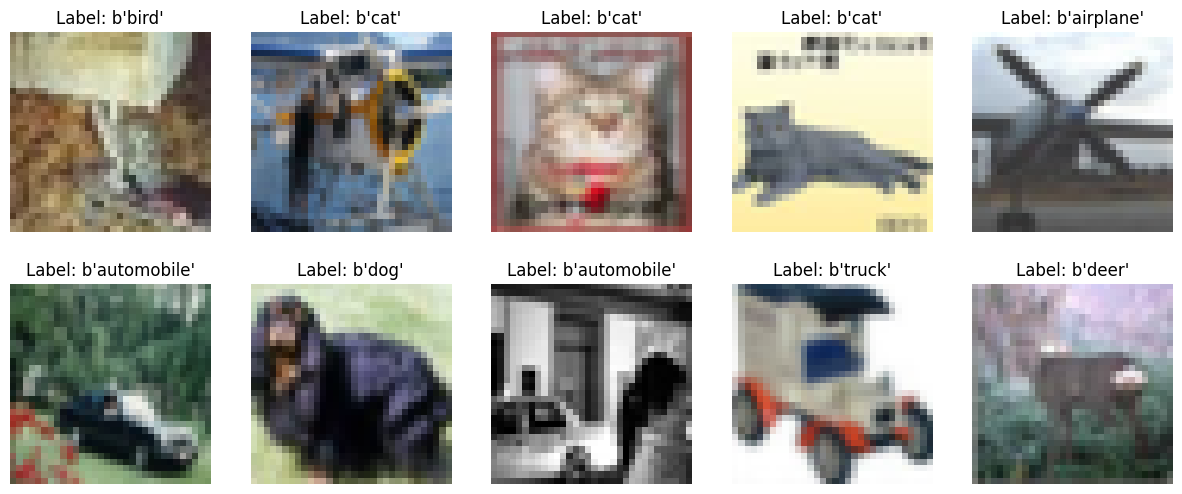

In [21]:
model.eval()

tta_transformations = [
    transforms.Lambda(lambda x: x),
    transforms.RandomHorizontalFlip(p=1),
    transforms.GaussianBlur(kernel_size=3),
    transforms.ColorJitter(contrast=0.5),
    transforms.ColorJitter(brightness=0.5)
]

image_ids = []
predicted_labels = []

with torch.no_grad():
    for inputs, image_ids_batch in tqdm(submission_loader, desc="Generating predictions with TTA"):
        inputs = inputs.to(device)
        
        augmented_outputs = []
        
        for transform in tta_transformations:
            augmented_inputs = torch.stack([transform(img) for img in inputs])
            augmented_inputs = augmented_inputs.to(device)

            outputs = model(augmented_inputs)
            augmented_outputs.append(outputs)
        
        avg_outputs = torch.mean(torch.stack(augmented_outputs), dim=0)
        
        _, predicted = torch.max(avg_outputs, 1)
        
        image_ids.extend(image_ids_batch.cpu().numpy()) 
        predicted_labels.extend(predicted.cpu().numpy())
        
df = pd.DataFrame({
    "ID": image_ids,
    "Labels": predicted_labels
})

csv_filename = 'predictions.csv'
df.to_csv(csv_filename, index=False)

print(f"Predictions saved to {csv_filename}")

meta_data_dict = load_cifar_batch(os.path.join(cifar10_dir, 'batches.meta'))
label_names = meta_data_dict[b'label_names']

df["Label Name"] = df["Labels"].map(lambda label: label_names[label])
headers = df

start_idx = 8090
end_idx = start_idx + 10

top_images = [submission_dataset[i][0] for i in range(start_idx, end_idx)]
top_labels = headers.iloc[start_idx:end_idx]["Label Name"]

fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i, ax in enumerate(axes.flat):
    ax.imshow(top_images[i].permute(1, 2, 0))
    ax.set_title(f"Label: {top_labels.iloc[i]}")
    ax.axis('off')